# Libraries

In [136]:
# import libraries

import os
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from keras.datasets import mnist
from keras.utils import to_categorical
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.optimizers import SGD
from keras.regularizers import l2
from sklearn.model_selection import train_test_split, KFold

# Functions

In [137]:
# unpickle the files
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [138]:
# load all CIFAR
def load_CIFAR10():

    train_images = np.zeros((50000, 32, 32, 3), dtype=np.uint8)
    train_labels = np.zeros((50000,), dtype=np.uint8)
    
    # get training data
    for i in range(5):
        train_dict = unpickle(f'./data/cifar-10-batches-py/data_batch_{i+1}')
        train_images[i*10000:(i+1)*10000] = train_dict[b'data'].reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
        train_labels[i*10000:(i+1)*10000] = train_dict[b'labels']

    # get testing data
    test_dict = unpickle('./data/cifar-10-batches-py/test_batch')
    test_images = test_dict[b'data'].reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
    val_labels = np.array(test_dict[b'labels'])

    # convert from integers to floats
    train_images = train_images.astype('float32')
    test_images = test_images.astype('float32')

    # scale image pixels to [0, 1]
    train_images, test_images = train_images / 255.0, test_images / 255.0

    # one hot encode target labels
    train_labels = to_categorical(train_labels)
    val_labels = to_categorical(val_labels)

    return ((train_images, train_labels), (test_images, val_labels))

In [139]:
def load_MNIST():
    (train_X, train_Y), (test_X, test_Y) = mnist.load_data()

    # scale image pixels to [0, 1]
    train_X, test_X = train_X / 255.0, test_X / 255.0

    # one hot encode target labels
    train_Y = to_categorical(train_Y)
    test_Y = to_categorical(test_Y)

    return (train_X, train_Y), (test_X, test_Y)

In [140]:
def load_Cho():
    # import cho dataset
    cols = ['Gene_ID', 'Ground_Truth_Cluster_ID', 'A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'A11', 'A12', 'A13', 'A14', 'A15', 'A16']
    df_cho = pd.read_csv('./data/cho.txt', sep="	", names=cols, header=None)

    return df_cho

In [141]:
def validation_CIFAR(images, labels):
    images, images_val, labels, labels_val = train_test_split(images, labels, test_size=0.1)

    print(f"New training/labels length: {len(images)}/{len(labels)}")
    print(f"New validation/labels length: {len(images_val)}/{len(labels_val)}")
    
    return ((images, labels), (images_val, labels_val))

In [142]:
def validation_Cho(df):
    kf = KFold(n_splits=10, shuffle=True)
 
    # extract the fold
    for train_index, test_index in kf.split(df):
        train_data = df.iloc[train_index].values
        train_labels = df.iloc[train_index]
        val_data = df.iloc[test_index].values
        val_labels = df.iloc[test_index]
    
    # remove ground truth column
    #train_data = np.delete(train_data, 1, 1)
    #val_data = np.delete(val_data, 1, 1)

    # reshape data for CNN
    train_data = np.reshape(train_data, (train_data.shape[0], 3, 6, 1))
    val_data = np.reshape(val_data, (val_data.shape[0], 3, 6, 1))

    # extract labels
    train_labels = train_labels.iloc[:, 1].values
    val_labels = val_labels.iloc[:, 1].values

    # one hot encode target labels
    train_labels = to_categorical(train_labels)
    val_labels = to_categorical(val_labels)

    print(f"New training/labels length: {len(train_data)}/{len(train_labels)}")
    print(f"New validation/labels length: {len(val_data)}/{len(val_labels)}")
    
    return (train_data, train_labels), (val_data, val_labels)

In [143]:
# (shape of the data, and the number of labels)
def build_model_CNN_baseline(shape, labels_size):
   
    # baseline 1-block VGG-style model
    model = models.Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=shape))
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(labels_size, activation='softmax'))
    
    # compile model
    opt = SGD(lr=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    
    # show summary 
    model.summary()
    return model

In [144]:
# (shape of the data, and the number of labels)
def build_model_CNN_tuned(shape, labels_size):

    # baseline 1-block VGG-style model + drop regularization
    model = models.Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=shape))
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dropout(0.2))
    model.add(Dense(labels_size, activation='softmax'))
    
    # compile model
    opt = SGD(lr=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    
    # show summary 
    model.summary()
    return model

In [145]:
def verify_CIFAR(data, labels):

    class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

    plt.figure(figsize=(10,10))
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        
        # show img
        plt.imshow(data[i], cmap=plt.cm.binary)
        
        # show label
        index = np.argmax(labels[i]).astype(int) # needed after one-hot encoding
        plt.xlabel(class_names[index])
        
    plt.show()

In [146]:
def verify_MNIST(data, labels):
    for i in range(9):  
        plt.subplot(330 + 1 + i)
        plt.imshow(data[i], cmap=plt.get_cmap('gray'))
        plt.show()

In [147]:
# plot diagnostic learning curves (History object, string data name, and string indicating validaiton or test set)
# graph showing loss & accuracy over the number of epochs
def show_diagnostics(history, dataset_name, val_or_test):

    # plot loss
    plt.subplot(211)
    plt.title('Cross Entropy Loss')
    plt.plot(history.history['loss'], color='blue', label='train')
    plt.plot(history.history['val_loss'], color='orange', label=val_or_test)
    
    # plot accuracy
    plt.subplot(212)
    plt.title('Classification Accuracy')
    plt.plot(history.history['accuracy'], color='blue', label='train')
    plt.plot(history.history['val_accuracy'], color='orange', label=val_or_test)
    
    # adjust visuals
    plt.suptitle('CNN - ' + dataset_name)
    plt.subplots_adjust(hspace=0.5)
    plt.legend()

    # save plot to file
    plt.show()
    #filename = os.getcwd()
    #plt.savefig(filename + '_' + dataset_name + '_evaluation.png')
    plt.close()

In [148]:
def prediction(model, test):
    # assuming your model is called 'model'
    pred = model.predict(test)

    # get the index of the class with the highest probability
    label = np.argmax(pred)

    # print result
    print(label)

# Run on CIFAR-10

In [149]:
def run_CIFAR10():
    (train_data, train_labels), (test_data, test_labels) = load_CIFAR10()

    print("\nVerifying Data...")

    verify_CIFAR(train_data, train_labels)

    print("Data Verified!\n")
    print("------------------------------------------------------------------")
    print("Creating Validation Set...")

    (train_data, train_labels), (validation_data, validation_labels) = validation_CIFAR(train_data, train_labels)

    print("Validation Set Created!\n")
    print("------------------------------------------------------------------")
    print("Building Model...")

    model_CIFAR = build_model_CNN((3, 3), (32, 32, 3), 10)

    print("Model Built!\n")
    print("------------------------------------------------------------------")
    print("Fitting Model...")

    history_CIFAR10 = model_CIFAR.fit(train_data, train_labels, epochs=2, batch_size=64, validation_data=(validation_data, validation_labels), verbose=0)

    print("Model Fitted!\n")

    # show learning curves
    show_diagnostics(history_CIFAR10, "CIFAR-10", "validation")
    # debug
    print(history_CIFAR10)
    print(history_CIFAR10.history['accuracy'])

    print("------------------------------------------------------------------")
    print("Evaluating Model...")

    # evaluate model
    test_loss, test_acc = model_CIFAR.evaluate(test_data,  test_labels)
    print("Loss: ", test_loss)
    print(f"Accuracy: {test_acc :.2%}") # 45.07%

    print("\nRun Complete!\n")
    return

# run_CIFAR10()

# Run on MNIST


Verifying Data...
Data Verified!

------------------------------------------------------------------
Building Model...
Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 28, 28, 32)        320       
                                                                 
 conv2d_25 (Conv2D)          (None, 28, 28, 32)        9248      
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 14, 14, 32)       0         
 g2D)                                                            
                                                                 
 flatten_12 (Flatten)        (None, 6272)              0         
                                                                 
 dense_24 (Dense)            (None, 128)               802944    
                                                                 

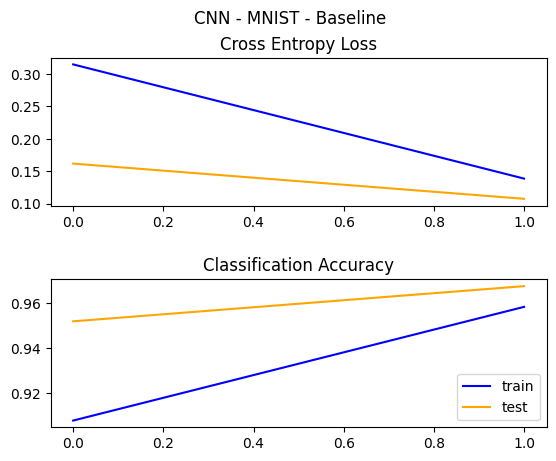

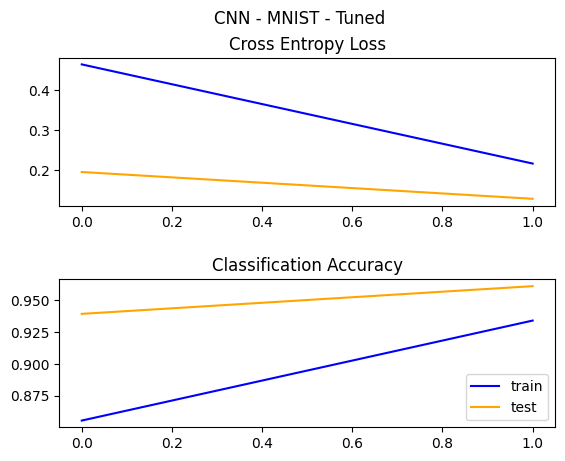


Run Complete!



SyntaxError: 'return' outside function (3336662300.py, line 42)

In [150]:
#def run_MNIST():
# load dataset
(train_images, train_labels), (test_images, test_labels) = load_MNIST()

print("\nVerifying Data...")

#verify_MNIST(train_images, train_labels)

print("Data Verified!\n")
print("------------------------------------------------------------------")
print("Building Model...")

model_MNIST_baseline = build_model_CNN_baseline((28, 28, 1), 10)
model_MNIST_tuned = build_model_CNN_tuned((28, 28, 1), 10)

print("Model Built!\n")
print("------------------------------------------------------------------")
print("Fitting Model...")

# fit model
history_MNIST_baseline = model_MNIST_baseline.fit(train_images, train_labels, epochs=2, batch_size=64, validation_data=(test_images, test_labels), verbose=0)
history_MNIST_tuned = model_MNIST_tuned.fit(train_images, train_labels, epochs=2, batch_size=64, validation_data=(test_images, test_labels), verbose=0)

print("Model Fitted!\n")
print("------------------------------------------------------------------")
print("Evaluating Model...")

# evaluate model
test_loss, test_acc = model_MNIST_baseline.evaluate(test_images,  test_labels)
print("Basline Loss: ", test_loss)
print(f"Basline Accuracy: {test_acc :.2%}")

test_loss, test_acc = model_MNIST_tuned.evaluate(test_images,  test_labels)
print("Tuned Loss: ", test_loss)
print(f"Tuned Accuracy: {test_acc :.2%}")

# show learning curves
show_diagnostics(history_MNIST_baseline, "MNIST - Baseline", "test")
show_diagnostics(history_MNIST_tuned, "MNIST - Tuned", "test")

print("\nRun Complete!\n")

# run_MNIST()

# Run on Cho


Verifying Data...
     Gene_ID  Ground_Truth_Cluster_ID    A1    A2    A3    A4    A5    A6  \
0          1                        1 -0.69 -0.96 -1.16 -0.66 -0.55  0.12   
1          2                        1 -0.21  0.19  0.86  0.04 -0.35 -0.39   
2          3                        1 -0.30 -0.56 -0.29 -0.50 -0.27 -0.29   
3          4                        1  0.07  0.26 -0.47 -0.68 -0.63 -0.39   
4          5                        1 -1.04  0.13  0.51 -0.44 -0.88 -0.32   
..       ...                      ...   ...   ...   ...   ...   ...   ...   
381      382                        5 -0.64 -0.76 -0.55 -0.68 -0.66 -0.09   
382      383                        5 -0.01 -0.82 -0.65 -0.43 -0.28 -0.48   
383      384                        5 -3.12 -4.12 -3.54 -1.54 -0.37  1.48   
384      385                        5 -0.79 -0.56 -0.79 -0.23 -0.53 -0.14   
385      386                        5 -1.16 -1.39 -0.96 -0.91 -0.71 -0.10   

       A7    A8    A9   A10   A11   A12    A13    A14   

c:\Users\z1297\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\optimizers\legacy\gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


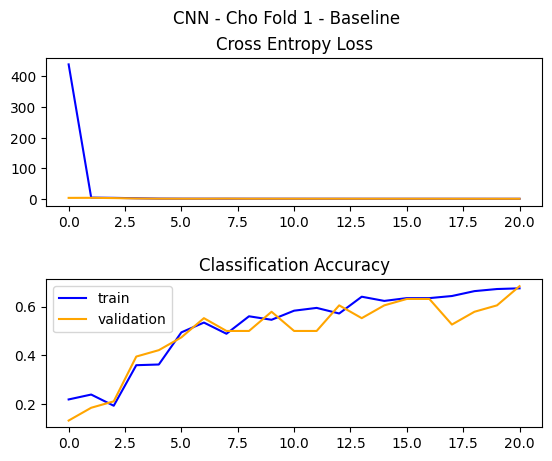

------------------------------------------------------------------
Evaluating Model...
2/2 [==============================] - 0s 13ms/step - loss: 1.0612 - accuracy: 0.6842
Loss:  1.061163067817688
Accuracy: 68.42%
Fold 1 Complete!
------------------------------------------------------------------
Creating Validation Set...
New training/labels length: 348/348
New validation/labels length: 38/38
------------------------------------------------------------------
Building Model...
Model: "sequential_133"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_283 (Conv2D)         (None, 3, 6, 32)          320       
                                                                 
 conv2d_284 (Conv2D)         (None, 3, 6, 32)          9248      
                                                                 
 max_pooling2d_138 (MaxPooli  (None, 1, 3, 32)         0         
 ng2D)                         

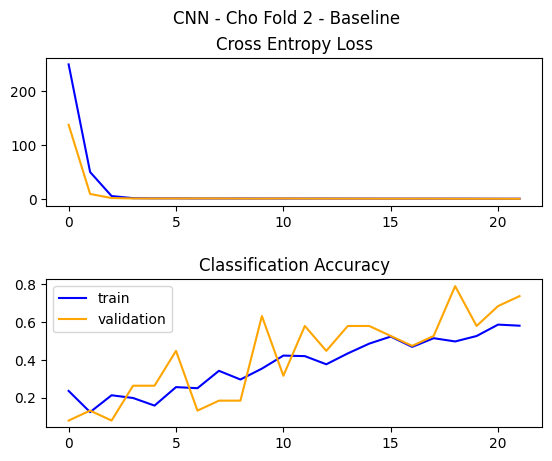

------------------------------------------------------------------
Evaluating Model...
2/2 [==============================] - 0s 8ms/step - loss: 0.9053 - accuracy: 0.7368
Loss:  0.9053378701210022
Accuracy: 73.68%
Fold 2 Complete!
------------------------------------------------------------------
Creating Validation Set...
New training/labels length: 348/348
New validation/labels length: 38/38
------------------------------------------------------------------
Building Model...
Model: "sequential_134"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_285 (Conv2D)         (None, 3, 6, 32)          320       
                                                                 
 conv2d_286 (Conv2D)         (None, 3, 6, 32)          9248      
                                                                 
 max_pooling2d_139 (MaxPooli  (None, 1, 3, 32)         0         
 ng2D)                         

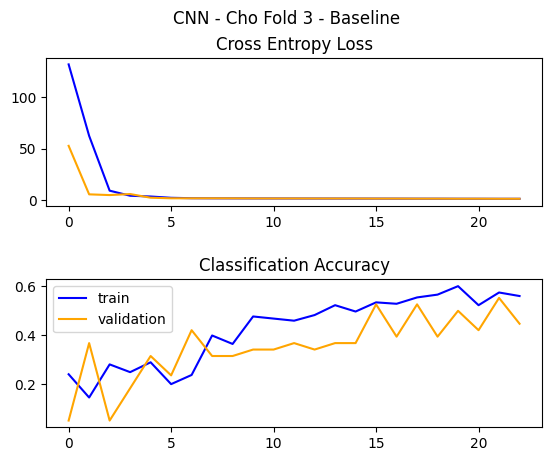

------------------------------------------------------------------
Evaluating Model...
2/2 [==============================] - 0s 5ms/step - loss: 1.1143 - accuracy: 0.4474
Loss:  1.1143028736114502
Accuracy: 44.74%
Fold 3 Complete!
------------------------------------------------------------------
Creating Validation Set...
New training/labels length: 348/348
New validation/labels length: 38/38
------------------------------------------------------------------
Building Model...
Model: "sequential_135"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_287 (Conv2D)         (None, 3, 6, 32)          320       
                                                                 
 conv2d_288 (Conv2D)         (None, 3, 6, 32)          9248      
                                                                 
 max_pooling2d_140 (MaxPooli  (None, 1, 3, 32)         0         
 ng2D)                         

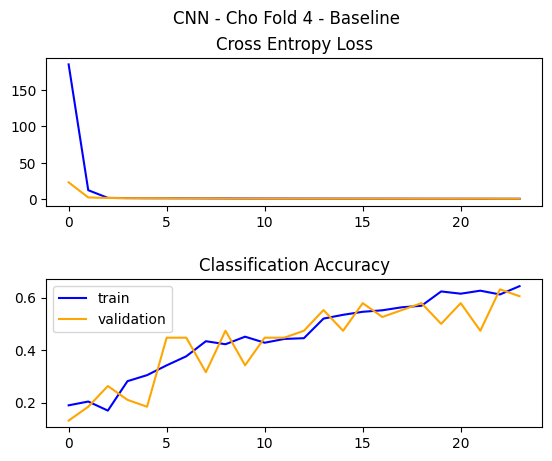

------------------------------------------------------------------
Evaluating Model...
2/2 [==============================] - 0s 7ms/step - loss: 0.9690 - accuracy: 0.6053
Loss:  0.9690436124801636
Accuracy: 60.53%
Fold 4 Complete!
------------------------------------------------------------------
Creating Validation Set...
New training/labels length: 348/348
New validation/labels length: 38/38
------------------------------------------------------------------
Building Model...
Model: "sequential_136"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_289 (Conv2D)         (None, 3, 6, 32)          320       
                                                                 
 conv2d_290 (Conv2D)         (None, 3, 6, 32)          9248      
                                                                 
 max_pooling2d_141 (MaxPooli  (None, 1, 3, 32)         0         
 ng2D)                         

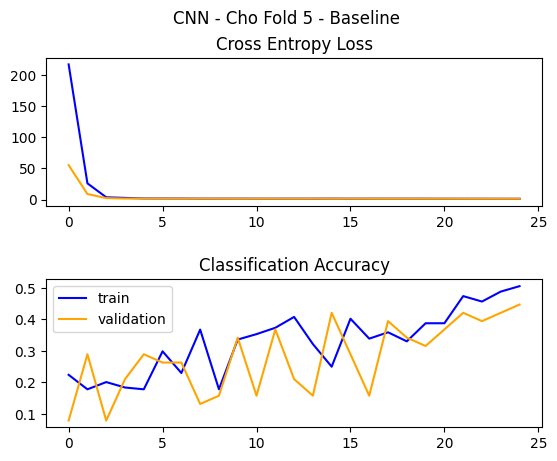

------------------------------------------------------------------
Evaluating Model...
2/2 [==============================] - 0s 9ms/step - loss: 1.3607 - accuracy: 0.4474
Loss:  1.360689401626587
Accuracy: 44.74%
Fold 5 Complete!
------------------------------------------------------------------
Creating Validation Set...
New training/labels length: 348/348
New validation/labels length: 38/38
------------------------------------------------------------------
Building Model...
Model: "sequential_137"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_291 (Conv2D)         (None, 3, 6, 32)          320       
                                                                 
 conv2d_292 (Conv2D)         (None, 3, 6, 32)          9248      
                                                                 
 max_pooling2d_142 (MaxPooli  (None, 1, 3, 32)         0         
 ng2D)                          

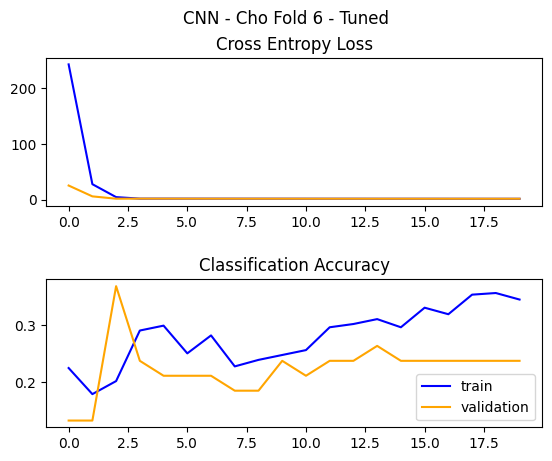

------------------------------------------------------------------
Evaluating Model...
2/2 [==============================] - 0s 4ms/step - loss: 1.5306 - accuracy: 0.2368
Loss:  1.5306205749511719
Accuracy: 23.68%
Fold 6 Complete!
------------------------------------------------------------------
Creating Validation Set...
New training/labels length: 348/348
New validation/labels length: 38/38
------------------------------------------------------------------
Building Model...
Model: "sequential_138"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_293 (Conv2D)         (None, 3, 6, 32)          320       
                                                                 
 conv2d_294 (Conv2D)         (None, 3, 6, 32)          9248      
                                                                 
 max_pooling2d_143 (MaxPooli  (None, 1, 3, 32)         0         
 ng2D)                         

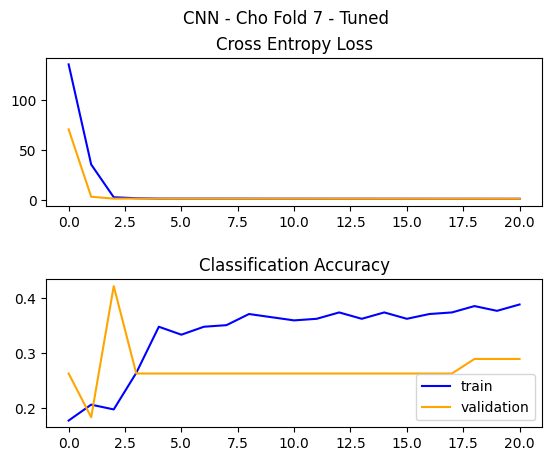

------------------------------------------------------------------
Evaluating Model...
2/2 [==============================] - 0s 6ms/step - loss: 1.5850 - accuracy: 0.2895
Loss:  1.5850343704223633
Accuracy: 28.95%
Fold 7 Complete!
------------------------------------------------------------------
Creating Validation Set...
New training/labels length: 348/348
New validation/labels length: 38/38
------------------------------------------------------------------
Building Model...
Model: "sequential_139"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_295 (Conv2D)         (None, 3, 6, 32)          320       
                                                                 
 conv2d_296 (Conv2D)         (None, 3, 6, 32)          9248      
                                                                 
 max_pooling2d_144 (MaxPooli  (None, 1, 3, 32)         0         
 ng2D)                         

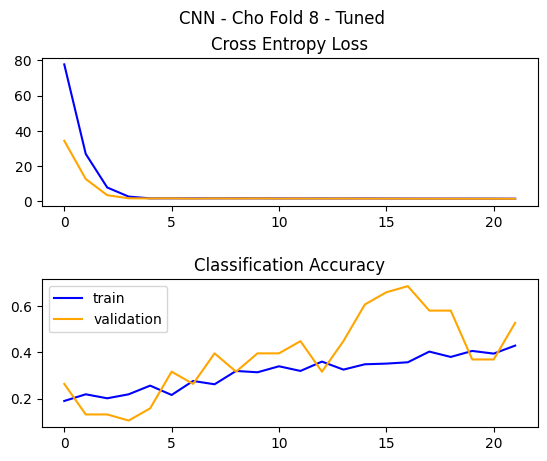

------------------------------------------------------------------
Evaluating Model...
2/2 [==============================] - 0s 6ms/step - loss: 1.3211 - accuracy: 0.5263
Loss:  1.3210710287094116
Accuracy: 52.63%
Fold 8 Complete!
------------------------------------------------------------------
Creating Validation Set...
New training/labels length: 348/348
New validation/labels length: 38/38
------------------------------------------------------------------
Building Model...
Model: "sequential_140"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_297 (Conv2D)         (None, 3, 6, 32)          320       
                                                                 
 conv2d_298 (Conv2D)         (None, 3, 6, 32)          9248      
                                                                 
 max_pooling2d_145 (MaxPooli  (None, 1, 3, 32)         0         
 ng2D)                         

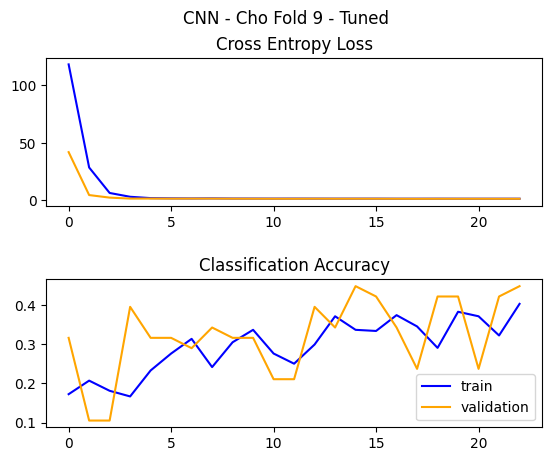

------------------------------------------------------------------
Evaluating Model...
2/2 [==============================] - 0s 5ms/step - loss: 1.4450 - accuracy: 0.4474
Loss:  1.4449653625488281
Accuracy: 44.74%
Fold 9 Complete!
------------------------------------------------------------------
Creating Validation Set...
New training/labels length: 348/348
New validation/labels length: 38/38
------------------------------------------------------------------
Building Model...
Model: "sequential_141"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_299 (Conv2D)         (None, 3, 6, 32)          320       
                                                                 
 conv2d_300 (Conv2D)         (None, 3, 6, 32)          9248      
                                                                 
 max_pooling2d_146 (MaxPooli  (None, 1, 3, 32)         0         
 ng2D)                         

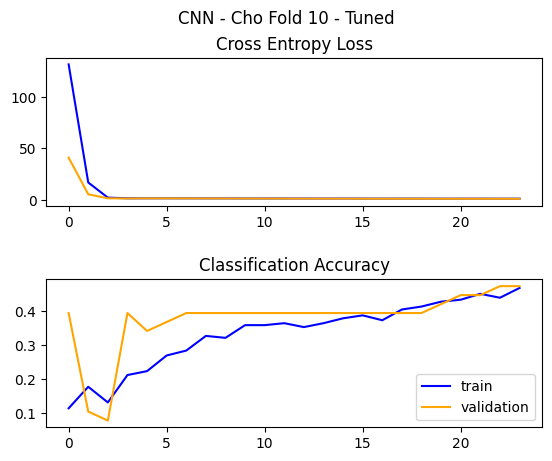

------------------------------------------------------------------
Evaluating Model...
2/2 [==============================] - 0s 5ms/step - loss: 1.1508 - accuracy: 0.4737
Loss:  1.1507967710494995
Accuracy: 47.37%
Fold 10 Complete!
------------------------------------------------------------------


In [ ]:
def run_Cho():
    
    # load dataset
    df_cho = load_Cho()

    print("\nVerifying Data...")

    print(df_cho)

    print("Data Verified!\n")
    print("------------------------------------------------------------------")

    # 10 fold cross-validation
    # folds 1-5 are baselines and folds 6-10 are tuned models
    # both baseline and tuned models run from epochs 20 - 25
    model_Cho = {}
    for i in range(1,11): #debugging on tuned model
        print("Creating Validation Set...")

        (train_data, train_labels), (val_data, val_labels) = validation_Cho(df_cho)

        print("------------------------------------------------------------------")
        print("Building Model...")

        if (i < 6):
            model_Cho[i-1] = build_model_CNN_baseline((3, 6, 1), 6) # 6 labels bcuz 0-5, but 0 is not used!
        else:
            model_Cho[i-1] = build_model_CNN_tuned((3, 6, 1), 6)

        print("------------------------------------------------------------------")
        print("Fitting Model...")

        # fit model
        if (i < 6):
            epochs = 20+i
        else:
            epochs = 20+(i-6)
        history_Cho = model_Cho[i-1].fit(train_data, train_labels, epochs=epochs, batch_size=64, validation_data=(val_data, val_labels), verbose=0)
        
        # show learning curves
        if (i < 6):
            show_diagnostics(history_Cho, "Cho Fold " + str(i) + " - Baseline", "validation")
        else:
            show_diagnostics(history_Cho, "Cho Fold " + str(i) + " - Tuned", "validation")

        print("------------------------------------------------------------------")
        print("Evaluating Model...")

        # evaluate model
        test_loss, test_acc = model_Cho[i-1].evaluate(val_data,  val_labels)
        print("Loss: ", test_loss)
        print(f"Accuracy: {test_acc :.2%}")
        
        print(f"Fold {i} Complete!")
        print("------------------------------------------------------------------")

#run_Cho()